# Rare-event estimation for the Random Geometric Graph

Let $X = \{X_i\}_{i \le N}$ be a homogeneous Poisson point process with intensity $\lambda > 0$ in a finite sampling window $W \subset \mathbb R^2$.

The  [Random Geometric Graph](https://en.wikipedia.org/wiki/Random_geometric_graph) $G(X)$ on $X$ connects any two points that are at most of a fixed distance, say 1. That is,  $X_i$ and $X_j$ are connected by an edge if  $|X_i - X_j| \le 1$.

This notebook explores the problem of estimating rare events in this random network. More precisely, we tackle the questions that the network has considerably more or considerably less edges than expected.

We first describe in detail how to efficiently represent the graph and query points. Then, we discuss the upper tails and lower tails separately. The key idea in both tails is the observation that the estimation problem relies on two sources of randomness, namely 

1. An infinite sequence of iid random vectors $\{X_i\}_{i \ge 1}$ describing the point locations and 
2. A Poisson random variable $N$ describing the actual point number

We leverage that when conditioned on the spatial locations, the remaining probability can be computed in closed form. Hence, by the [Rao-Blackwell theorem](https://en.wikipedia.org/wiki/Rao%E2%80%93Blackwell_theorem) we are guaranteed to obtain an estimator that is more efficient than crude Monte Carlo.

## Graph Generation

We begin by discussing how to generate the points $X$ and the associated graph $G(X)$. First, we frequently need to query points in specified regions in the plane. To make this possible efficiently, we arrange the indices representing points in a  two-dimensional grid.

In [1]:
win_len = 20
import numpy as np

def point_grid(points,
               win_len = win_len,
               bins = win_len):
    """Grid arranging points indices
    
        # Arguments
            points: finite point set
            win_len: sampling window length
            bins: number of bins in each coordinate
        # Result
            Grid arranging points indices
    """
    grid = [[[] for _ in range(bins)] for _ in range(bins)]
    for i, (x, y) in enumerate(points):
        grid[int(x * bins / win_len)][int(y * bins / win_len)] += [i]
    return np.array(grid)

We represent a geometric graph through its adjacency list.

In [2]:
import graph_tool.all as gt
def geom_graph_adj(vertices,
                   r = 1):
    """Adjacency list of geometric graph
    
        # Arguments
            vertices: graph vertices
            rad: radius of the geometric graph
        # Result
            Adjacency list of geometric graph
    """
    gg = gt.geometric_graph(vertices, r, None)[0]
    return  np.array([gg.get_all_neighbors(v) for v in gg.vertices()])

To extract neighbors of a given point efficiently, we only look at points in a suitable neighborhood of a given bin.

In [3]:
def neighbs_coarse(bin_coords,
                   grid,
                   scope = 1):
    """Indices of points in neighboring bins
    
        # Arguments
            bin_coords: coordinates of considered bin
            grid: grid arranging point indices
            scope: size of neighborhood
        # Result
            Indices of points in neighboring bins
    """
    x, y = bin_coords
    
    #extract points from neighboring boxes
    return [idx for points in (grid[(max(x - scope, 0)):(x + scope + 1),
                                    (max(y - scope, 0)):(y + scope + 1)]).flatten() 
            for idx in points]
     

## Visualization

To visualize the convergence of the estimators, we first compute means and standard deviations of the estimators over rolling windows. 

In [3]:
def mean_std(series,
            subset = int(1e1)):
    """rolling mean and std of a time series
    
        # Arguments
            series: a time series
            subset: only compute estimates at subset of all times
        # Result
            mean and std of a time series
    """
    rol_mean = np.cumsum(series * 1.) / np.arange(1, len(series) + 1)
    
    subset_ints = np.arange(1, len(series) + 1, subset)
    rol_std = np.array([np.std(series[: (i + 1)] * 1.) 
                        for i in subset_ints]) / np.sqrt(subset_ints)
    return rol_mean[::-subset][::-1], rol_std

Then, we plot the moving average together with the standard deviation as shaded area.

In [4]:
import matplotlib.pyplot as plt

def plot_with_bars(curve, 
                   sd,
                   figsize = (18, 5),
                   color = 'b',
                   alpha = .2):
    """Plot with error bars
    
        # Arguments
            curve: curve
            sd: size of error bars
            figsize: figure size
            color: bar color
            alpha: bar translucent alpha
        # Result
            Plot with error bars
    """
    pd.Series(curve).plot(figsize=figsize,
                          color = 'black'
                       )
    
    plt.ylim(0, 1.1 * sorted(curve + sd)[-2])
    plt.fill_between(range(len(curve)), 
                 curve - sd, 
                 curve +  sd, 
                 color = color, 
                 alpha = alpha)

## Conditional Monte Carlo

Loosely speaking, the Poisson point
process consists of 1) an infinite sequence of random points in the window determining the
locations of points and 2) a Poisson random number determining the number of points in the
sampling window. We leverage that after conditioning on the spatial locations, the rare-event
probability is available in closed form

### Lower Tails

First, we proceed to estimating rare-event probabilities associated with the lower tails of the edge counts. That is, we consider events of the form 
$$E_a^- = \{K < (1 - a)\mathbb E[K]\}.$$
Also in this setting, we leverage that after conditioning on the locations $\{X_n\}_{n \ge 1}$, the rare-event probabilities are available in closed form. More precisely, there exists an almost surely finite random variable $N_a^- = N_a^-(X_\infty)$ such that the random geometric graph on the nodes $\{X_1, \dots, X_k\}$ contains at most $(1 - a)\mathbb E[K]$ edges if and only if $k \le N_a^-$. Then,

$$\mathbb P(E_a^-) = \mathbb E_{X_\infty}[\mathbb P(E_a^-\,|\,X_\infty)] = \mathbb E_{X_\infty}[\mathsf{Pois}(N \le N_a^-(X))].$$

In [5]:
from scipy.stats import poisson
def rao_low(rnd,         
            ntarget = .8 * 3795.74294,
            win_len = 25,        
            lambda_ = 2,           
            r = 1,
            freq_print = int(1e4)):  
    """Estimate for lower tails for edge counts via Rao-Blackwell
    
        # Arguments
            rnd: Current iteration round
            ntarget: number of edges to exceed
            win_len: window length
            lambda_: intensity of Poisson process
            r: radius
            freq_print: frequency of log messages
        # Result
            Estimate for upper tails for edge counts via Rao-Blackwell
    """   

    #print progress
    np.random.seed(rnd)    
    if(rnd % freq_print == 0):
        print('')
        print(rnd, flush = True)
        
    locs, survivors, adj_list = init_low(win_len, lambda_)
    npoints = len(adj_list)
    nedges = len(np.concatenate(adj_list))/2
    
    while(nedges > ntarget):
            #select point and remove from survivors
            npoints -= 1      
            sel_idx = int(np.random.rand() * npoints)
            point_idx = survivors[sel_idx]
            survivors = np.delete(survivors, sel_idx)
            
            #count removed edges
            neighbs = adj_list[point_idx]
            nedges -= len(neighbs)
            
            #remove from neighbs
            adj_list[point_idx] = []
            for neighb in neighbs:
                adj_list[neighb] = np.setdiff1d(adj_list[neighb], point_idx)
            
    #expected number of points
    nexp = lambda_ * win_len ** 2
    return poisson.cdf(npoints, nexp)

def init_low(win_len,
            lambda_):
    """Initialize data structures for upper tail estimation
    
        # Arguments
            win_len: window length
            lambda_: intensity of Poisson process
        # Result
            number of points, number of edges, 
            point location, grid of points, indices of surviving points
            and neighbor list
    """   
    #expected number of points
    nexp = lambda_ * win_len ** 2
    
    #heuristic bounds on minimum and maximum number of points needed
    npoints = int(nexp)
        
    #gen random points
    locs = np.random.rand(npoints, 2) * win_len
    
    #indices of surviving points
    survivors = list(range(npoints))
    
    #count edges
    adj_list = geom_graph_adj(locs)
    
    return locs, survivors, adj_list

### Upper Tails

Henceforth, let $K$ denote the number of edges in the random geometric graph. In this section, we discuss how to efficiently estimate the probability the probability of the rare event 
$$E = \{K > (1 + a) \mathbb E[K]\}$$
that the random geometric graph contains considerably more edges than expected. As announced in Section, we rely on the [Rao-Blackwell theorem](https://en.wikipedia.org/wiki/Rao%E2%80%93Blackwell_theorem) by conditioning on the spatial locations $X_\infty = \{X_i\}_{i \ge 1}$. More precisely, since the number of edges increases as we add further points, there exists an almost surely finite random variable $N_a = N_a(X_\infty)$ such that the random geometric graph on the nodes $\{X_1, \dots, X_k\}$ contains at least $(1 + a)\mathbb E[K]$ edges if and only if $k \ge N_a^+$. 

By construction of the Poisson point process, the total number of points $N$ is distributed according to $\mathsf{Poi}(\lambda |W|)$ and independent of $X_\infty$. Hence,
$$\mathbb P(E) = \mathbb E_{X_\infty}[\mathbb P(E\,|\,X_\infty)] = \mathbb E_{X_\infty}[\mathsf{Pois}(N \ge N_a^+(X))].$$

In [7]:
from scipy.stats import poisson

def rao_up(rnd,
           ntarget = 1.2 * 3795.742944,
           win_len = 25,
           lambda_ = 2, 
           r = 1,
           freq_print = int(1e4)):  
    """Estimate for upper tails for edge counts via Rao-Blackwell
    
        # Arguments
            rnd: Current iteration round
            ntarget: number of edges to exceed
            win_len: window length
            lambda_: intensity of Poisson process
            r: radius
            freq_print: frequency of log messages
        # Result
            Estimate for upper tails for edge counts via Rao-Blackwell
    """   
    
    #print progress
    np.random.seed(rnd)    
    if(rnd % freq_print == 0):
        print('')
        print(rnd, flush = True)
        
    npoints, nedges, locs, grid = init_up(win_len,
                                          lambda_)
    
    while(nedges < ntarget): 
            #generate new point            
            npoints += 1    
            rpoint = locs[npoints]
            x, y = np.array(rpoint, int)

            #count added edges
            neighbs = neighbs_coarse([x, y], 
                                     grid)
            nedges += np.sum([np.hypot(*(rpoint - locs[neighb])) < r 
                              for neighb in neighbs])

            #add new point            
            grid[x, y] += [npoints]
            
    #expected number of points
    nexp = lambda_ * win_len ** 2
    return 1 - poisson.cdf(npoints - 1, nexp)

def init_up(win_len,
            lambda_):
    """Initialize data structures for upper tail estimation
    
        # Arguments
            win_len: window length
            lambda_: intensity of Poisson process
        # Result
            number of points, number of edges, point location, grid
    """   
    #expected number of points
    nexp = lambda_ * win_len ** 2
    
    #heuristic bounds on minimum and maximum number of points needed
    npoints = int(nexp)
    npoints_max = 2 * npoints
        
    #gen random points
    locs = np.random.rand(npoints_max, 2) * win_len
    
    #set up grid
    grid = point_grid(locs[:npoints],
                      win_len,
                      win_len)

    #count edges
    adj_list = geom_graph_adj(locs[:npoints])
    nedges = len(np.concatenate(adj_list))/2
    
    return npoints, nedges, locs, grid

## Importance Sampling

### Lower Tails

As for the upper tails, we can strengthen the estimator by combining the Rao-Blackwell estimator with importance sampling on the spatial locations. The key observation is that under the rare event of seeing exceptionally few edges, we expect a repulsion between the points. We implement this repulsion by a dependent thinning mechanism inspired from the Strauss process. 

Here, we start from a realization of the network based on iid points $\{X_1, \dots, X_{n_0}\}$, where $n_0 = \lambda |W|$ denotes the expected number of points. Then, we thin out points successively with probability proportional to $\gamma^{\mathsf{deg}(X_i)}$, where $\mathsf{deg}(X_i)$ denotes the degree of $X_i$ in the random geometric graph and $\gamma > 1$ is a parameter of the algorithm.

In [8]:
from scipy.stats import poisson

def rao_low_is(rnd,
              ntarget = .8 * 3795.7,
              win_len = 25,
              gamma = 1.02,
              lambda_ = 2, 
              r = 1,
              freq_print = int(1e4)):
    """Estimate for lower tails for edge counts via Rao-Blackwell augmented 
    by importance sampling
    
        # Arguments
            rnd: Current iteration round
            ntarget: number of edges to exceed
            win_len: window length
            gamma: parameter governing clustering during birth
            lambda_: intensity of Poisson process
            r: radius
            freq_print: frequency of log messages
        # Result
            Estimate for lower tails for edge counts via Rao-Blackwell augmented 
            by importance sampling
    """   
    
    #print progress
    np.random.seed(rnd)    
    if(rnd % freq_print == 0):
        print('')
        print(rnd, flush = True)
        
    locs, survivors, adj_list = init_low(win_len, lambda_)
    npoints = len(adj_list)
    nedges = len(np.concatenate(adj_list))/2
    
    #initialize thinning weights and normalizing constant
    degs = np.array([len(neighbs) for neighbs in adj_list])
    weight_un = gamma ** degs
    norm = np.sum(weight_un)
    
    #track likelihood
    ll = 1
    
    while(nedges > ntarget): 
            #select point and remove from survivors
            sel_idx = np.random.choice(range(npoints), 
                                        p = weight_un[survivors] / norm)
            point_idx = survivors[sel_idx]
            survivors = np.delete(survivors, sel_idx)
            
            #count removed edges
            neighbs = adj_list[point_idx]
            nedges -= len(neighbs)
            
            #update likelihood and weights
            ll *= npoints * weight_un[point_idx] / norm
            norm += np.sum(weight_un[neighbs] * (1/gamma - 1)) - weight_un[point_idx] 
            weight_un[neighbs] /= gamma
            
            #remove from neighbs
            npoints -= 1 
            adj_list[point_idx] = []
            for neighb in neighbs:
                adj_list[neighb] = np.setdiff1d(adj_list[neighb], point_idx)
 
    #expected number of points
    nexp = lambda_ * win_len ** 2
    return poisson.cdf(npoints, nexp) / ll

The estimator constructed above takes into account the observation that if the random geometric graph exhibits considerably more edges than expected, then one reason is that there are more points than expected. However, not only the number but also the location of points should play a  pivotal role. When points arrange into clusters, then it is easier to create a large number of edges.

We propose to take this feature into account via a birth mechanism favoring the generation of points in areas that would lead to a large number of additional edges. Then, we correct for this perturbation in the probability mechanism through importance sampling

For computational reasons the density of the birth mechanism is discretized and remains constant in bins of a suitably chosen grid. More precisely, the density in a bin at position $x \in W$ is proportional to $\gamma^{n(x)}$. Here, $\gamma > 1$ is a parameter governing the strength of the clustering and $n(x)$ denotes the number of Poisson points in a suitable neighborhood around $x$.

In [9]:
from scipy.stats import poisson

def rao_up_is(rnd,
              ntarget = 1.2 * 3795.742944,
              win_len = 25,
              bins = 50,
              gamma = 1.01,
              lambda_ = 2, 
              r = 1,
              freq_print = int(1e4)):  
    """Estimate for upper tails for edge counts via Rao-Blackwell augmented by importance sampling
    
        # Arguments
            rnd: Current iteration round
            ntarget: number of edges to exceed
            win_len: window length
            bins: number of bins for discretization
            gamma: parameter governing clustering during birth
            lambda_: intensity of Poisson process
            r: radius
            freq_print: frequency of log messages
        # Result
            Estimate for upper tails for edge counts via Rao-Blackwell augmented by importance sampling
    """   
    
    #print progress
    np.random.seed(rnd)    
    if(rnd % freq_print == 0):
        print('')
        print(rnd, flush = True)
        
    npoints, nedges, locs, grid = init_up_is(win_len,
                                             lambda_,
                                             bins)
    
    #initialize birth weights and normalizing constant
    weight_un, norm = init_weights_up(grid,
                                      bins,
                                      win_len,
                                      gamma)
    
    #track likelihood
    ll = 1
    
    while(nedges < ntarget): 
            #generate new point according to weights        
            npoints += 1    
            
            #generate edges according to kern
            bin_idx = np.random.choice(len(weight_un), 
                                        p = weight_un / norm)
            x, y = bin_idx // bins, bin_idx % bins
            rpoint = (np.random.rand(2) + np.array([x, y])) * win_len / bins
            locs[npoints] = rpoint
            
            rpoint = locs[npoints]
            
            #update likelikehood
            ll *= bins**2 * weight_un[bin_idx] / norm            
            
            #count added edges
            neighbs = neighbs_coarse([x, y], 
                                     grid,
                                     bins // win_len)
            nedges += np.sum([np.hypot(*(rpoint - locs[neighb])) < r 
                              for neighb in neighbs])

            #add new point            
            grid[x, y] += [npoints]
            
            #update unnormalized weights and normalizing constant
            weight_update = update_weights([x, y],
                                           bins,
                                           win_len,
                                           gamma)           
            norm += np.sum(weight_un *(weight_update - np.ones(bins**2)))
            weight_un *= weight_update
            
    #expected number of points
    nexp = lambda_ * win_len ** 2
    return (1 - poisson.cdf(npoints - 1, nexp)) / ll

def init_up_is(win_len,
               lambda_,
               bins):
    """Initialize data structures for upper tail estimation
    
        # Arguments
            win_len: window length
            lambda_: intensity of Poisson process
            bins: number of bins for the discretization
        # Result
            number of points, number of edges, point location, grid
    """   
    #expected number of points
    nexp = lambda_ * win_len ** 2
    
    npoints = int(nexp)
        
    #gen random points
    locs = np.random.rand(2 * npoints, 2) * win_len
    
    #set up grid
    grid = point_grid(locs[:npoints],
                      win_len,
                      bins)

    #count edges
    adj_list = geom_graph_adj(locs[:npoints])
    nedges = len(np.concatenate(adj_list))/2
    
    return npoints, nedges, locs, grid

To complete the algorithm, we need to specify how to initialize and update the weights.

In [10]:
from scipy import signal

def init_weights_up(grid,
                    bins,
                    win_len,
                    gamma):
    """Initialize unnormalized weights and normalizing constant
    
        # Arguments
            grid:  grid arranging point indices
            bins: number of bins
            win_len: window length
            gamma: number of bins for the discretization
        # Result
            unnormalized weights and normalizing constant
    """   
    #count points per cell
    before_conv = [[len(p) for p in row] for row in grid]
    
    #mimic edge count through convolution
    scope = bins // win_len
    after_conv = signal.convolve(before_conv, 
                                 np.ones([2 * scope + 1, 2 * scope + 1]),
                                 mode = 'same')
    
    #return unnormalized weights and normalizing constant
    weight_un = gamma ** (after_conv.flatten())
    norm = np.sum(weight_un)
    
    return weight_un, norm

def update_weights(coords,
                   bins,
                   win_len,
                   gamma):
    """Compute increment for weight update
    
        # Arguments
            bins: number of bins
            win_len: window length
            gamma: number of bins for the discretization
        # Result
            unnormalized weights and normalizing constant
    """   
    x, y = coords
    weight_inc = np.zeros([bins, bins])
    
    #each point increases weights in surrounding bins
    scope = bins // win_len
    weight_inc[(max(x - scope, 0)):(x + scope + 1),(max(y - scope, 0)):(y + scope + 1)] = 1
    
    return gamma ** (weight_inc.flatten())
    

## Simulation Results

Now, we showcase in a simulation study that the improved estimators can reduce the variance by several orders of magnitude.

### Conditional Monte Carlo

To begin with, we describe conditional Monte Carlo without importace sampling. We start with the results for the lower tails.

In [11]:
import pandas as pd
import numpy as np

wins = [20, 25, 30]
cmc_lows = [pd.read_csv('./Data/low/{}.csv'.format(win), header = None).values for win in wins]

print([np.mean(cmc) for cmc in cmc_lows])
print([np.std(cmc) for cmc in cmc_lows] / np.sqrt(int(1e5)))
[(np.sqrt(np.mean(cmc))/np.std(cmc))**2 for cmc in cmc_lows]

[0.0020232575732567486, 0.0001542211773427759, 6.912377043171458e-06]
[6.98442416e-06 7.04600175e-07 4.18772608e-08]


[414.7534070575858, 3106.4081779516155, 39415.849106560556]

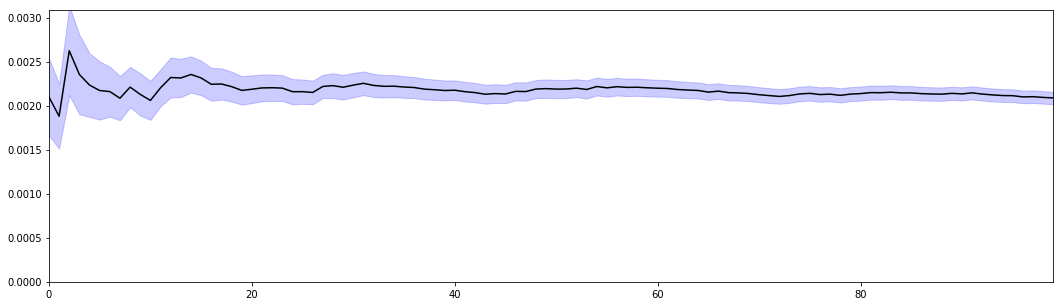

In [17]:
runs = int(1e3)
plot_with_bars(*mean_std(cmc_lows[0][:runs]))

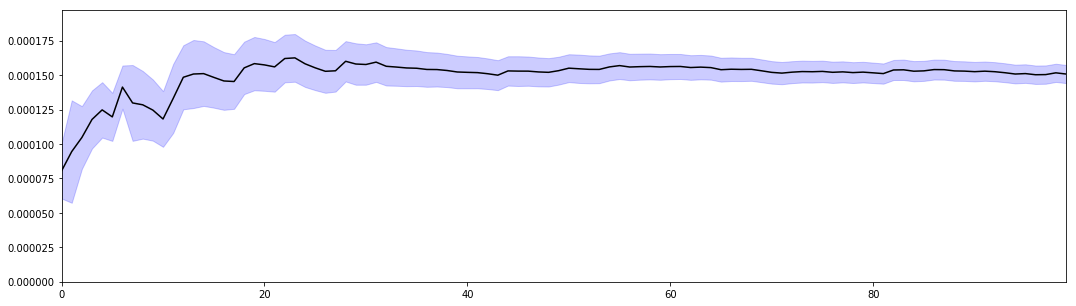

In [18]:
plot_with_bars(*mean_std(cmc_lows[1][:runs]))

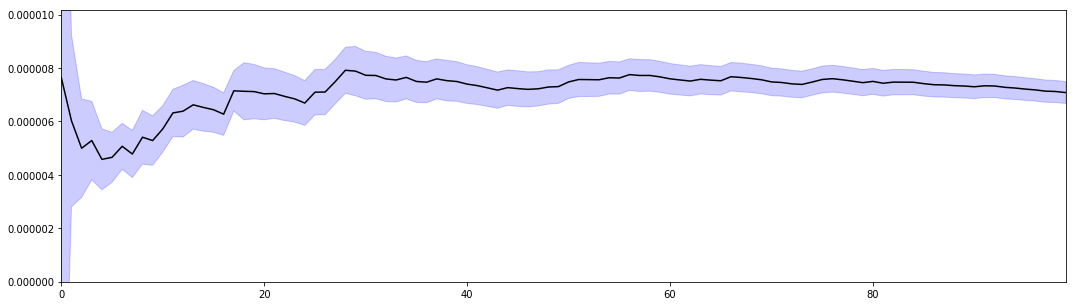

In [19]:
plot_with_bars(*mean_std(cmc_lows[2][:runs]))

Next, we repeat the analysis for the upper tails.

In [5]:
import pandas as pd
import numpy as np

wins = [20, 25, 30]
cmc_ups = [pd.read_csv('./Data/up/{}.csv'.format(win), header = None).values for win in wins]

print([np.mean(cmc) for cmc in cmc_ups])
print([np.std(cmc) for cmc in cmc_ups] / np.sqrt(int(1e5)))
[(np.sqrt(np.mean(cmc))/np.std(cmc))**2 for cmc in cmc_ups]

[0.0051182862537835615, 0.0006764017503752302, 6.242189184460934e-05]
[1.62564908e-05 2.77464249e-06 3.24962640e-07]


[193.67384035489803, 878.5989018973802, 5911.123852969805]

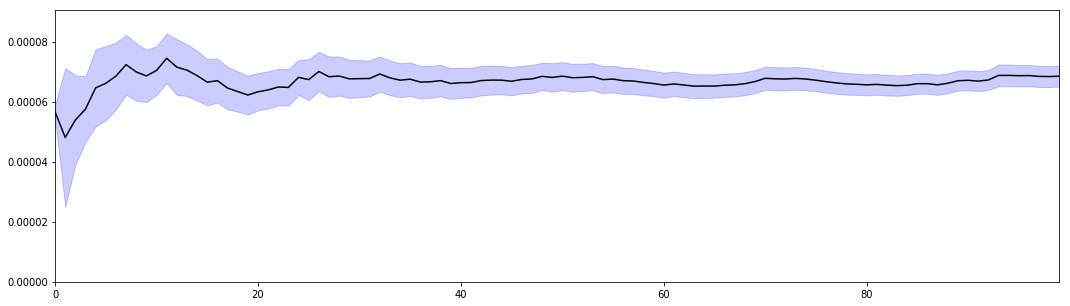

In [14]:
runs = int(1e3)
plot_with_bars(*mean_std(cmc_ups[0][:runs]))

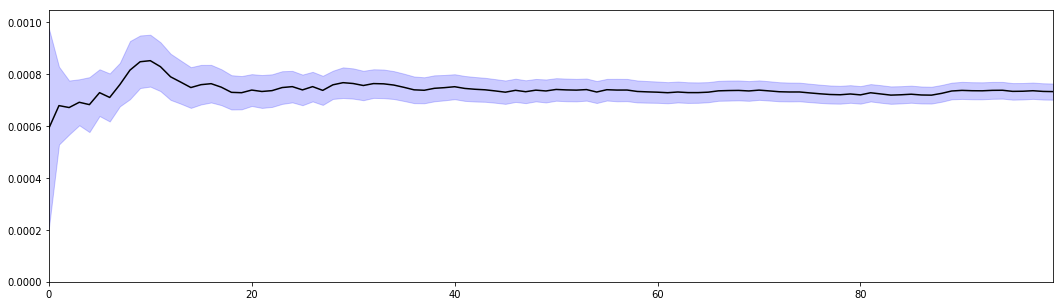

In [15]:
plot_with_bars(*mean_std(cmc_ups[1][:runs]))

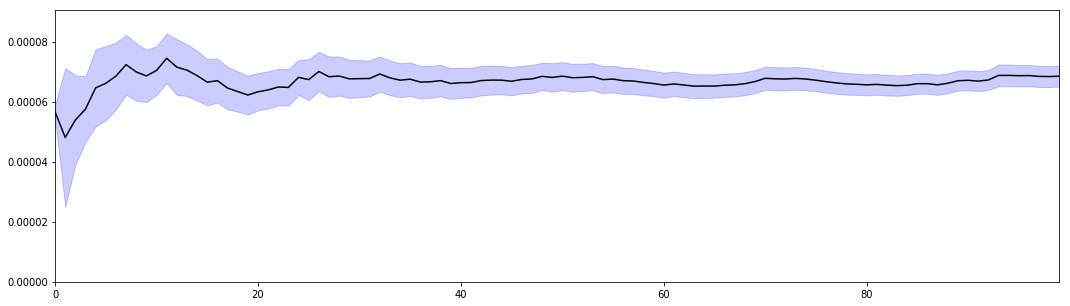

In [16]:
plot_with_bars(*mean_std(cmc_ups[2][:runs]))

### Importance sampling

Finally, we add importance sampling.

In [12]:
import pandas as pd
import numpy as np

wins = [20, 25, 30]
ips_lows = [pd.read_csv('./Data/low/{}_is_cranch.csv'.format(win), header = None).values for win in wins]

print([np.mean(ips) for ips in ips_lows])
print([np.std(ips) for ips in ips_lows] / np.sqrt(int(1e5)))
[(np.sqrt(np.mean(ips))/np.std(ips))**2 for ips in ips_lows]

[0.002025372211990753, 0.00015444685963571003, 6.935015949990297e-06]
[6.22106299e-06 6.15939868e-07 3.62877081e-08]


[523.3300216075721, 4071.0126468190347, 52665.7636978447]

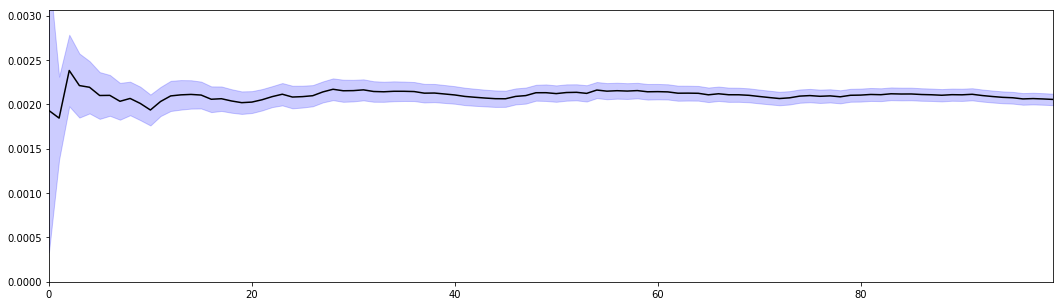

In [20]:
runs = int(1e3)
plot_with_bars(*mean_std(ips_lows[0][:runs]))

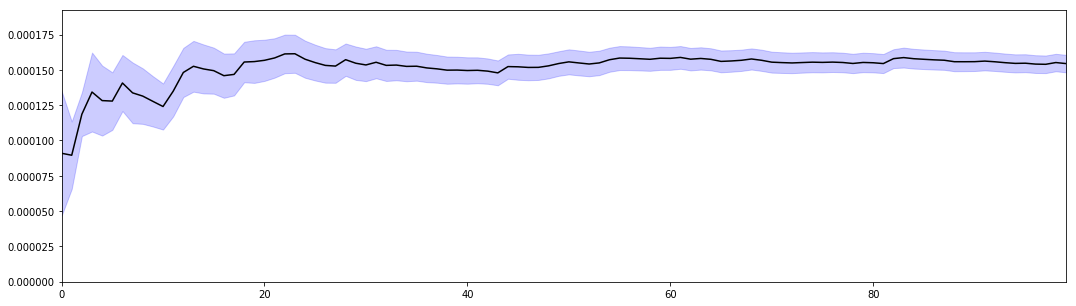

In [21]:
plot_with_bars(*mean_std(ips_lows[1][:runs]))

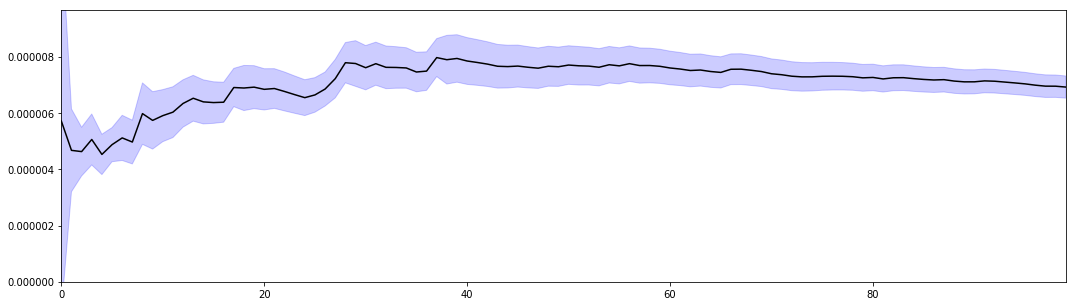

In [22]:
plot_with_bars(*mean_std(ips_lows[2][:runs]))

In [7]:
import pandas as pd
import numpy as np

wins = [20, 25, 30]
ips_ups = [pd.read_csv('./Data/up/{}_is.csv'.format(win), header = None).values for win in wins]

print([np.mean(ips) for ips in ips_ups])
print([np.std(ips) for ips in ips_ups] / np.sqrt(int(1e5)))
[(np.sqrt(np.mean(ips))/np.std(ips))**2 for ips in ips_ups]

[0.00512483023926579, 0.0006743928029798622, 6.239863205494748e-05]
[1.56995381e-05 2.66182753e-06 3.08951874e-07]


[207.92453367118623, 951.8162242522731, 6537.224506323654]

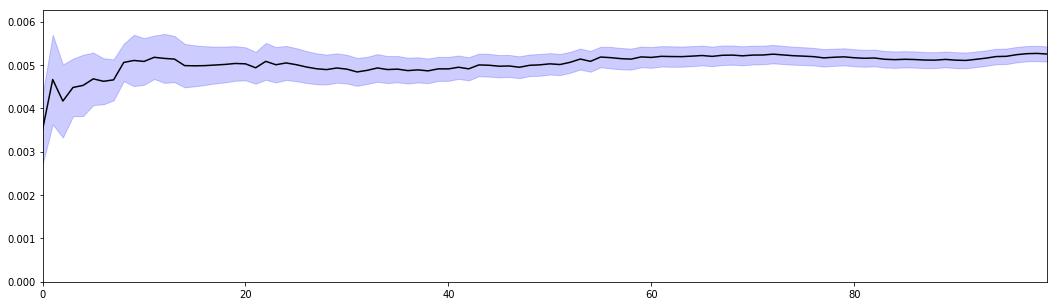

In [12]:
runs = int(1e3)
plot_with_bars(*mean_std(ips_ups[0][:runs]))

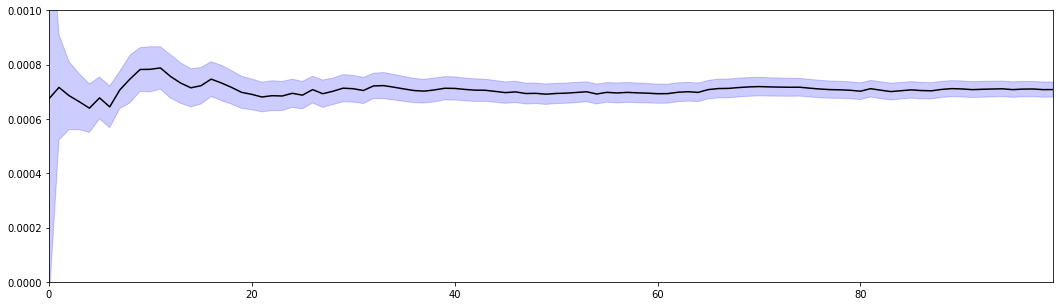

In [13]:
plot_with_bars(*mean_std(ips_ups[1][:runs]))

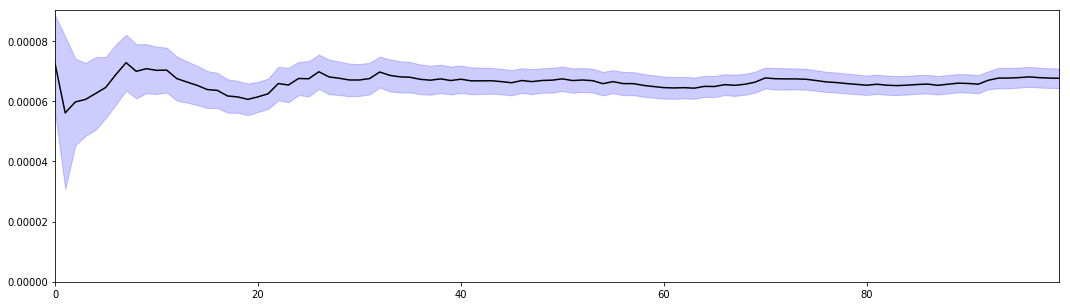

In [14]:
plot_with_bars(*mean_std(ips_ups[2][:runs]))